#### 공사비 전처리

##### 학습대상 공사비 레코드
* 계약전력: 50이하
* 접수종류명: 신설(상용/임시)
* 총공사비: 30,000,000이하 (최소 총공사비: 73,9093)
* 공사형태명: '외선소요'

In [3]:
import re
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from utils.plt_setting import plt_settings
from utils.data_manager import read_data, write_data, common_columns

# 한글처리 지원
plt_settings()

In [4]:
_start_time = datetime.now()
_df_cons = read_data('CONS_INFO', data_type='provide')

print(
    f'Total Elapsed Time for Data Load: {datetime.now()-_start_time}\n'
    f'Shape: {_df_cons.shape}'
)

Total Elapsed Time for Data Load: 0:00:27.574977
Shape: (19052, 143)


In [5]:
df_cons = _df_cons.copy()

#### 데이터 전처리

##### 결측값 처리

In [6]:
# 결측치 값 상태 체크
df_cons.isna().sum().sort_values(ascending=False)[:4]

신기술공종규격코드    19052
전선변압기코드번호    19052
CUD상태코드      19052
공사번호             0
dtype: int64

In [7]:
# '신기술공종규격코드', '전선변압기코드번호', '상태코드' 3컬럼이 모두 결측치이기 때문에,
# 단일값인 0으로 치환 후 이후 단일값으로 구성된 컬럼 삭제시 제거
df_cons.fillna(0, inplace=True)

##### 학습대상 레코드 추출

In [8]:
# 학습대상 레코드 조건
training_data_conditions = \
    (df_cons['접수종류명'] == '신설(상용/임시)') & \
    (df_cons['계약전력'] < 50) & \
    (df_cons['공사형태코드'] == 2) & \
    (df_cons['총공사비'] < 30000000)
    
# 학습대상 이외의 데이터 건수 확인
df_cons[~training_data_conditions].shape

(3717, 143)

In [9]:
# 전체 레코드(19,052)중에 3,158건으로 예외로 제거
# (제거 후 인덱스를 갱신함)
df_cons = df_cons[training_data_conditions].reset_index(drop=True)

##### 1차 컬럼제거: 1개의 값으로 구성된 컬럼

In [10]:
num_unique_data_pre_column = df_cons.nunique()
single_value_columns = \
    num_unique_data_pre_column[num_unique_data_pre_column == 1].index

# 하나의 값으로 구성된 컬럼 제거
df_cons.drop(columns=single_value_columns, axis=1, inplace=True)

# 결과확인
print(
    f'Before Number of Columns: {len(num_unique_data_pre_column)}\n'
    f'Number of Drop Columns: {len(single_value_columns)}\n'
    f'Columns: {[col for col in single_value_columns]}\n'
    f'Data shape: {df_cons.shape}'
)

Before Number of Columns: 143
Number of Drop Columns: 89
Columns: ['공사변경순번', '배전공사형태코드', '외자분재료비', '사업소재료비금액', '간접재료비', '작업부산물값', '전선변압기코드번호', '전선변압기추가금액', '전선변압기조정금액', '인력분기준비용', '기계분기준비용', '할선분기준비용', '전선기술노무비', '전선기술재료비', '전선기술경비', '무정전기술노무비', '무정전기술경비', '도급분무정전기술노무비', '도급분무정전기술경비', '감리총공사비', '폐기물총공사비', '자동화총공사비', '도통시험총공사비', '전주가지지공법노무비', '전주가지지공법경비', '공통공사비', '가설공사비1', '가설공사비2', '공동장비비용', '현장관리비', '직접공사비', '회사분직접공사비', '도급분직접공사비', '간접공사비', '가공분단위시설별공사비', '지중분단위시설별공사비', '가공분회사분재료비', '지중분회사분재료비', '가공분도급분재료비', '지중분도급분재료비', '감리자본적금액', '감리수익적금액', '폐기자본적금액', '폐기수익적금액', '도통자본적금액', '도통수익적금액', '자동화자본적금액', '자동화수익적금액', '자본대비자본적비율', '수익대비수익적비율', '원형전주버팀목공법자재비', '원형전주버팀목공법노무비', '원형전주버팀목공법경비', '도급분원형전주버팀목공법자재비', '도급분원형전주버팀목공법노무비', '도급분원형전주버팀목공법경비', '더블블레이드총공사비', '더블블레이드자본금액', '더블블레이드수익금', '사급자재자체감리비', '고객부담자체감리비', '부대공사자체감리비', '신기술공종규격코드', '신기술공사비', '신기술적용대수', '신기술적용선로길이', '중공스크루로드총공사비', '중공스크루로드자본적금액', '중공스크루로드수익적금액', 'CUD상태코드', '손실보상금', '손실보상계수', '무정전전선이선공사비', '무정전전선이선특허사용료율', '방호대총공사비', '방호대자본

#### 주요 컬럼 데이터 분석

##### 공사번호

In [11]:
# 공사번호에 영문 포함 여부 확인
df_cons['공사번호'][df_cons['공사번호'].str.contains('[a-zA-Z]')].shape

# - 공사번호에 영문이 포함된 레코드가 2,189개 존재
# - 공사번호 자체를 학습에 사용하지 않기 때문에 Key로서 보관

(2117,)

##### 날짜 데이터
* `최종등록일시`, `최종변경일시`
* 날짜 데이터의 타입과 두 날짜의 차이 등을 확인

In [12]:
# 날짜 데이터 타입 확인
df_cons[['최초등록일시', '최종변경일시']].info()

# - 다행히 두 날짜가 모두 날짜 형식을 띄고 있기 때문에 별도 형변환 안함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15335 entries, 0 to 15334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   최초등록일시  15335 non-null  datetime64[ns]
 1   최종변경일시  15335 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 239.7 KB


In [13]:
# 날짜 데이터 값 확인
df_cons[['최초등록일시', '최종변경일시']].head(2)

# 정상적인 날짜 데이터로 잘 들어가 있는데, 시간차이가 없음

,최초등록일시,최종변경일시
0,2022-11-21 17:45:02,2022-11-21 17:45:02
1,2020-10-19 09:06:23,2020-10-19 09:06:23


In [14]:
# 최초등록일시와 최종변경일시가 각각 의미가 있는가를 판단하기 위해
# 두 일시의 차이 계산(하루 미만이면 하나(최종변경일시)만 학습에 사용)
SECONDS_PER_HOUR = 60 * 60
difference_time = (df_cons['최종변경일시'] - df_cons['최초등록일시'])
difference_time_condition = (
    difference_time.dt.total_seconds() >= SECONDS_PER_HOUR
)

df_cons[difference_time_condition].shape

# - '최초등록일시'와 '최종변경일시'가 한시간 이상 차이나는 레코드가 없기 때문에
#   '최종변경일시'만 사용

(0, 54)

In [15]:
df_cons['year'] = df_cons['최종변경일시'].dt.year
df_cons['month'] = df_cons['최종변경일시'].dt.month
df_cons['day'] = df_cons['최종변경일시'].dt.day
df_cons['dayofweek'] = df_cons['최종변경일시'].dt.dayofweek
df_cons['dayofyear'] = df_cons['최종변경일시'].dt.dayofyear

In [16]:
df_cons['year_month'] = df_cons['최종변경일시'].dt.strftime('%Y%m').astype(int)

In [17]:
type(df_cons['year_month'][0]), df_cons['year_month'][11]

(numpy.int64, 202009)

##### 사번
* `최초등록자사번` vs `최종변경자사번`
* 두 값이 같으면 `최종변경자사번`을 사용하고, 다르면 `둘 다 사용`할 것인가 고민

In [18]:
difference_eid_condition = df_cons['최초등록자사번'] != df_cons['최종변경자사번']
df_cons[difference_eid_condition].shape

# - 다행이 두 사번이 다른 레코드가 없기 때문에 '최종변경자사번'만 사용

(0, 60)

In [19]:
# 사번에서 앞에 있는 영문 추출해 새로운 컬럼인 `eid_code`에 추가
df_cons['eid_code'] = \
    df_cons['최종변경자사번'].str.extract('([a-zA-Z]+)', expand=False)
    
# `eid_code`의 종류가 몇개인가 확인하고 종류별 갯 수 확인
df_cons.eid_code.value_counts(), df_cons.eid_code.value_counts().sum()

# - 8개 코드 종류가 있고(의미는 모름),
# - 8개의 값의 합이 13,966으로 전체 15,335보다 적음: 일부 NaN값이 존재

(eid_code
 MDP    5956
 MDE    5362
 MDF    1028
 MDO     840
 MDA     654
 MDJ     114
 MMP      11
 MDI       1
 Name: count, dtype: int64,
 13966)

In [20]:
# NaN값에 특정 값 추가: 여기서는 'AAA'
df_cons.eid_code.fillna('AAA', inplace=True)

# 이 값을 학습에 사용하기 용의하도록 숫자로 된 컬럼 추가
# - 문자열로 되어있는 컬럼을 숫자로 변경하는 방법도 있고, 
#   One-Hot Encoding 방법(나중에 해당 값을 연산할 경우 좋음)도 존재함
df_cons['eid_code_number'] = \
    df_cons.eid_code.rank(method='dense').astype(int)
    
# 변경 여부 확인
df_cons.eid_code_number.value_counts()

eid_code_number
8    5956
3    5362
1    1369
4    1028
7     840
2     654
6     114
9      11
5       1
Name: count, dtype: int64

In [21]:
# 정확한 변경 여부를 값으로 확인
# - 각 갑별로 데이터프레임의 첫번째 레코드의 인덱스를 저장해, 해당 인덱스만 출력
sorted_unique_eid_code = sorted(df_cons.eid_code.unique())
first_index_of_unique_eid_code = []
for eid_code in sorted_unique_eid_code:
    first_index = df_cons[df_cons.eid_code == eid_code].index[0]
    first_index_of_unique_eid_code.append(first_index)
    
_df_unique_eid = df_cons.iloc[first_index_of_unique_eid_code]
_df_unique_eid[['최종변경자사번', 'eid_code', 'eid_code_number']]

,최종변경자사번,eid_code,eid_code_number
30,2019106241,AAA,1
2563,MDA1570558,MDA,2
0,MDE1900011,MDE,3
3877,MDF1710844,MDF,4
3876,MDI1781912,MDI,5
7794,MDJ1563132,MDJ,6
952,MDO2100010,MDO,7
115,MDP2100146,MDP,8
7898,MMP1900092,MMP,9


In [22]:
# 사번에서 숫자만 추출해 별도 보관(학습에 사용할 수 있도록)
df_cons['eid_number'] = \
    df_cons['최종변경자사번'].apply(lambda x: re.findall(r'\d+', x)[0]).astype(int)

##### 사업소명
* 한글 사업소 코드를 숫자로 변경(학습에 사용할 수 있도록)

In [23]:
df_cons.사업소명.value_counts(), df_cons.사업소명.value_counts().sum()

# 사업소명의 각 갯 수의 합과 전체 레코드 수가 같기 때문에 사업소명에는 NaN값이 없음

(사업소명
 증평괴산지사    2117
 동청주지사     1774
 충주지사      1701
 영동지사      1485
 제천지사      1445
 보은지사      1317
 음성지사      1282
 충북본부직할    1267
 옥천지사      1149
 진천지사      1013
 단양지사       785
 Name: count, dtype: int64,
 15335)

In [24]:
# 사업소명을 숫자로 변경
df_cons['office_number'] = \
    df_cons.사업소명.rank(method='dense').astype(int)
    
# 신규 컬럼을 이용해 갯 수 확인
df_cons.office_number.value_counts()

office_number
8     2117
2     1774
11    1701
4     1485
7     1445
3     1317
6     1282
10    1267
5     1149
9     1013
1      785
Name: count, dtype: int64

#### 중요 컬럼명 영문으로 변경

In [25]:
df_cons.rename(columns={
    '공사번호': common_columns['공사번호'],
    '총공사비': common_columns['총공사비'],
    '최종변경일시': common_columns['최종변경일시'],
    '최종변경자사번': common_columns['최종변경자사번'],
    '사업소명': common_columns['사업소명'],
    '계약전력': common_columns['계약전력'],
}, inplace=True)

#### 학습에 필요한 컬럼 추출 및 저장(전체 데이터도 별도 저장)

In [26]:
training_columns = [
    'cons_id', 'total_cons_cost', 'last_mod_date', 'last_mod_eid', 
    'office_name', 'eid_code', 'cont_cap', 
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'year_month',
    'eid_code_number', 'eid_number', 'office_number', 
]

df_training = df_cons[training_columns]

In [27]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15335 entries, 0 to 15334
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cons_id          15335 non-null  object        
 1   total_cons_cost  15335 non-null  int64         
 2   last_mod_date    15335 non-null  datetime64[ns]
 3   last_mod_eid     15335 non-null  object        
 4   office_name      15335 non-null  object        
 5   eid_code         15335 non-null  object        
 6   cont_cap         15335 non-null  int64         
 7   year             15335 non-null  int32         
 8   month            15335 non-null  int32         
 9   day              15335 non-null  int32         
 10  dayofweek        15335 non-null  int32         
 11  dayofyear        15335 non-null  int32         
 12  year_month       15335 non-null  int64         
 13  eid_code_number  15335 non-null  int64         
 14  eid_number       15335 non-null  int64

In [28]:
write_data('1a-cons-all', df_cons)
write_data('1a-cons-training', df_training)

#### 차트로 확인

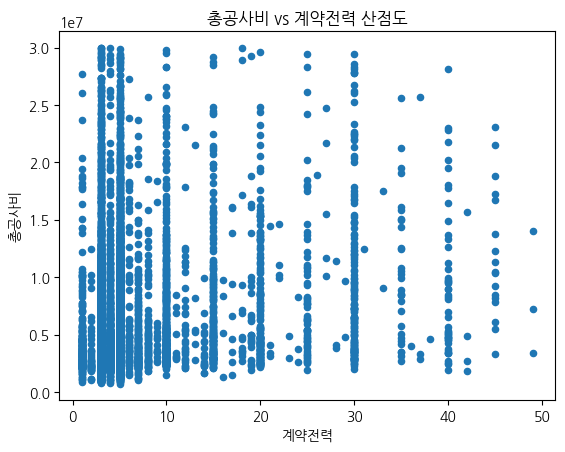

In [29]:
# 전체 데이터: 계약전력 vs 총공사비
df_cons.plot.scatter(x='cont_cap', y='total_cons_cost')
plt.xlabel('계약전력')
plt.ylabel('총공사비')
plt.title('총공사비 vs 계약전력 산점도')
plt.show()

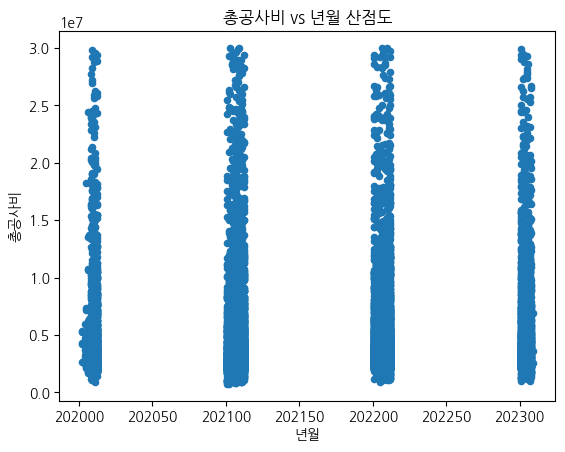

In [30]:
# 전체 데이터: 년월 vs 총 공사비
df_cons.plot.scatter(x='year_month', y='total_cons_cost')
plt.xlabel('년월')
plt.ylabel('총공사비')
plt.title('총공사비 vs 년월 산점도')
plt.show()

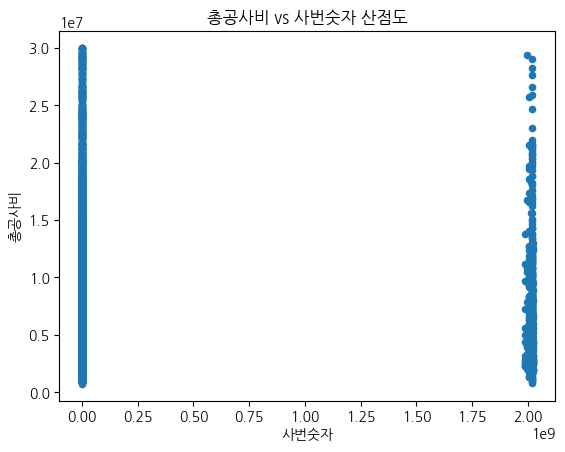

In [31]:
# 전체 데이터: 숫자 사번 vs 총 공사비
df_cons.plot.scatter(x='eid_number', y='total_cons_cost')
plt.xlabel('사번숫자')
plt.ylabel('총공사비')
plt.title('총공사비 vs 사번숫자 산점도')
plt.show()

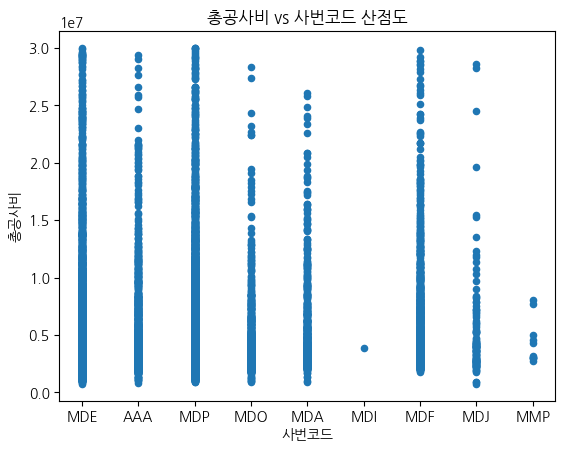

In [32]:
# 전체 데이터: 사번 코드 vs 총 공사비
df_cons.plot.scatter(x='eid_code', y='total_cons_cost')
plt.xlabel('사번코드')
plt.ylabel('총공사비')
plt.title('총공사비 vs 사번코드 산점도')
plt.show()

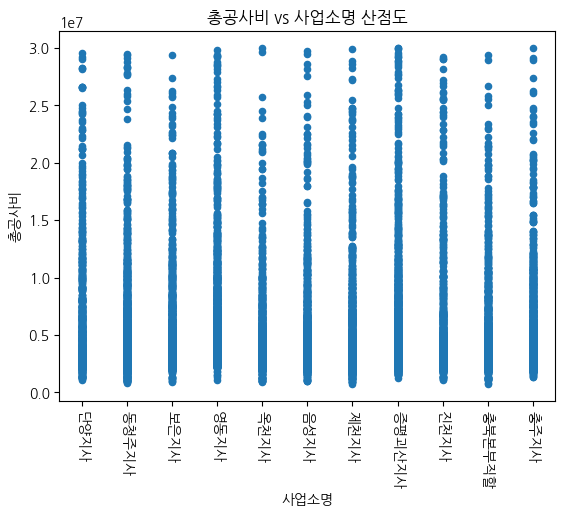

In [33]:
# 전체 데이터: 사업소명 vs 총 공사비
df_cons.plot.scatter(x='office_name', y='total_cons_cost')
plt.xlabel('사업소명')
plt.xticks(rotation=270)
plt.ylabel('총공사비')
plt.title('총공사비 vs 사업소명 산점도')
plt.show()